# Gesture Recognition with Confusion Matrix and ROC Analysis

In this notebook, we explore the performance of our gesture recognition model through various evaluation metrics, with a focus on visualizing the results using confusion matrices and ROC curves. Gesture recognition is a crucial aspect of human-computer interaction, enabling more intuitive and natural interfaces. By leveraging deep learning techniques, we aim to accurately classify a range of gestures from video data.

## Objectives

1. **Model Evaluation**: 
   - Generate predictions from our trained gesture recognition model.
   - Evaluate its performance using confusion matrices, which provide insights into how well the model distinguishes between different gesture classes.

2. **Performance Metrics**: 
   - Compute metrics such as precision, recall, F1 score, and specificity for each gesture class. 
   - These metrics are essential for understanding the strengths and weaknesses of our model, especially in cases of class imbalance.

3. **ROC Analysis**: 
   - Visualize the Receiver Operating Characteristic (ROC) curves for each class. 
   - Assess the trade-offs between true positive rates and false positive rates across different classification thresholds.
   - Calculate the area under the ROC curve (AUC) as a summary statistic for model performance.

By the end of this notebook, we aim to compare performance of our models effectiveness in recognizing gestures and identify areas for potential improvement.


### Function to load model architecture from .json and weights from .h5

In [3]:
from tensorflow.keras.models import model_from_json
file_prefix1 = "new_jester_3DCNN"
file_prefix2 = "new_jester_3DCNN_lstm"
file_prefix3 = "new_jester_3DCNN_lstm_rms"
file_prefix4 = "new_jester_3DCNN_plain_adam_cnn" #best
#other models:
#with only 1 color channel:less accuracy
#16 frames passed instead of 36:less accuracy->nan error


def load_model(file_path):
    # Load the model architecture from the JSON file
    with open(file_path + '.json', "r") as json_file:
        model_json = json_file.read()
    
    model = model_from_json(model_json)
    
    # Load weights into the model
    model.load_weights(file_path + '.h5')
    
    return model

cnn3d_model = load_model('{}_model'.format(file_prefix1))
cnn3d_lstm_model=load_model('{}_model'.format(file_prefix2))
cnn3d_lstm_model1=load_model('{}_model'.format(file_prefix3))
cnn3d_lstm_model2=load_model('{}_model'.format(file_prefix4)) #only 1 lstm layer

In [4]:
import pandas as pd
import numpy as np
from glob import glob
import skimage.transform
from skimage import io
from sklearn.preprocessing import OneHotEncoder
import joblib
import tensorflow as tf

C:\Users\Shriya Bhat\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
gesture_list = ['Swiping Right','Swiping Left','Thumb Up','Thumb Down','No gesture','Zooming In With Full Hand','Zooming Out With Full Hand']

#train
file_prefix = "new_jester_3DCNN_lstm"
df = pd.read_csv('./annotations/jester-v1-train.csv',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_train.csv'.format(file_prefix),sep=';',index=False)
# pd.read_csv('jester-v1-8classes_train.csv',sep=";").head()
print(df.shape)
print(df.head())
#val
df = pd.read_csv('./annotations/jester-v1-validation.csv',sep=';',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_val.csv'.format(file_prefix),sep=';',index=False)
print(df.shape)
print(df.head())

print('Csvs done')

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size=2, image_dim=(256,256), frames_count=36, n_channels=1, base_dir='./20bn-jester-v1/', n_classes=27,validation=False):
        self.image_dim = image_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = True 
        self.frames_count = frames_count
        self.df = pd.read_csv(file_path,sep=";")
        self.df.id = self.df.id.map(str)
        if "train" in file_path:
            self.encoder = OneHotEncoder(sparse_output=False)
            self.encoder.fit(self.df.labels.values[:,None])
            joblib.dump(self.encoder,"{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
            np.save("encoder_classes_{}_npy.npy".format(n_classes),self.encoder.categories_)
        else:
            self.encoder = joblib.load("{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
        self.base_dir = base_dir
        self.on_epoch_end()

    def __len__(self):
        ## Decides step_size
        return self.df.shape[0] // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = self.df.loc[indexes,"id"].to_list()
        X, y = self.__data_generation(indexes)
        return X, y 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.df.shape[0])
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size,self.frames_count, *self.image_dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=str)
        y = []
        for i, ID in enumerate(indexes):
            files_list = self.standardize_frame_count(glob(self.base_dir + self.df.loc[ID,"id"] + "/*.jpg"),self.df.loc[ID])
            for idx,filename in enumerate(files_list):
                X[i,idx] = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename,color_mode='grayscale',target_size=self.image_dim))
            y.append(self.df.loc[ID,"labels"])
        encoded = self.encoder.transform(np.array(y)[:,None])
        return X,encoded
        
    def standardize_frame_count(self,files,error_check):
        shape = len(files)
        if shape < self.frames_count:
            to_add = self.frames_count - shape
            mid  = len(files)//2
            dup = [files[mid]]*to_add
            files = files[:mid] + dup + files[mid+1:]
        elif shape > self.frames_count:
            to_remove = (shape - self.frames_count)
            to_remove = int(to_remove) if int(to_remove) == to_remove else int(to_remove) + 1
            files = files[to_remove:]
        return files
    
params = {'batch_size': 56,
          'n_classes': len(gesture_list),
          'n_channels': 3,
          'image_dim': (32,32)
          }

validation_generator = DataGenerator(file_path="{}_val.csv".format(file_prefix),**params)


(29819, 2)
        id                      labels
7   136859                    Thumb Up
8    68574               Swiping Right
13   20706                  No gesture
14   42237                  Thumb Down
19  133442  Zooming Out With Full Hand
(3640, 2)
       id                     labels
0    9223                   Thumb Up
2   42920               Swiping Left
3  106485                 Thumb Down
6   35341  Zooming In With Full Hand
7   94928              Swiping Right
Csvs done


C:\Users\Shriya Bhat\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# 1. 3D CNN model - baseline model

In [8]:
cnn3d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 34, 30, 30, 64)    5248      
                                                                 
 batch_normalization (Batch  (None, 34, 30, 30, 64)    256       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 34, 15, 15, 64)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 13, 13, 128)   221312    
                                                                 
 batch_normalization_1 (Bat  (None, 32, 13, 13, 128)   512       
 chNormalization)                                                
                                                        

### Function to print all evaluation metrics

In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import label_binarize

def plot_confusion_matrices(model, validation_generator, gesture_list):
    # Generate predictions
    Y_pred = []
    Y_true = []
    Y_prob = []  # To store predicted probabilities

    for i in range(len(validation_generator)):
        x, y = validation_generator[i]
        preds = model.predict(x)
        Y_pred.extend(preds.argmax(axis=1))  # Get predicted classes
        Y_true.extend(y.argmax(axis=1))       # Get true classes
        Y_prob.extend(preds)                   # Get predicted probabilities

    # Calculate the confusion matrix
    cm = metrics.confusion_matrix(Y_true, Y_pred, labels=np.arange(len(gesture_list)))

    # Function to plot confusion matrix
    def plot_confusion_matrix(ax, cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, normalize=False):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.around(cm, decimals=2)
            cm[np.isnan(cm)] = 0.0

        ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticklabels(classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            cell_value = format(cm[i, j], fmt)
            ax.text(j, i, cell_value,
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Calculate metrics
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    accuracy = np.sum(TP) / np.sum(cm)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = TN / (TN + FP)

    # Print metrics
    metrics_str = f'Overall Accuracy: {accuracy:.2%}\n'
    for i, class_name in enumerate(gesture_list):
        metrics_str += (f'{class_name}: Precision: {precision[i]:.2%}, '
                        f'Recall: {recall[i]:.2%}, '
                        f'F1 Score: {f1_score[i]:.2%}, '
                        f'Specificity: {specificity[i]:.2%}\n')

    # Create subplots for confusion matrices
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot raw confusion matrix
    plot_confusion_matrix(axs[0], cm, gesture_list, title='Raw Confusion Matrix')
    # Plot normalized confusion matrix
    plot_confusion_matrix(axs[1], cm, gesture_list, title='Normalized Confusion Matrix', normalize=True)

    # Add metrics text to the figure
    plt.figtext(0.5, 0.01, metrics_str, ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC
    Y_true_bin = label_binarize(Y_true, classes=np.arange(len(gesture_list)))
    Y_prob = np.array(Y_prob)  # Convert to NumPy array for processing

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(gesture_list)):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_true_bin[:, i], Y_prob[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    for i in range(len(gesture_list)):
        plt.plot(fpr[i], tpr[i], label=f'{gesture_list[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


2024-10-18 16:26:43.746041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2/2 [==============================] - 0s 40ms/step


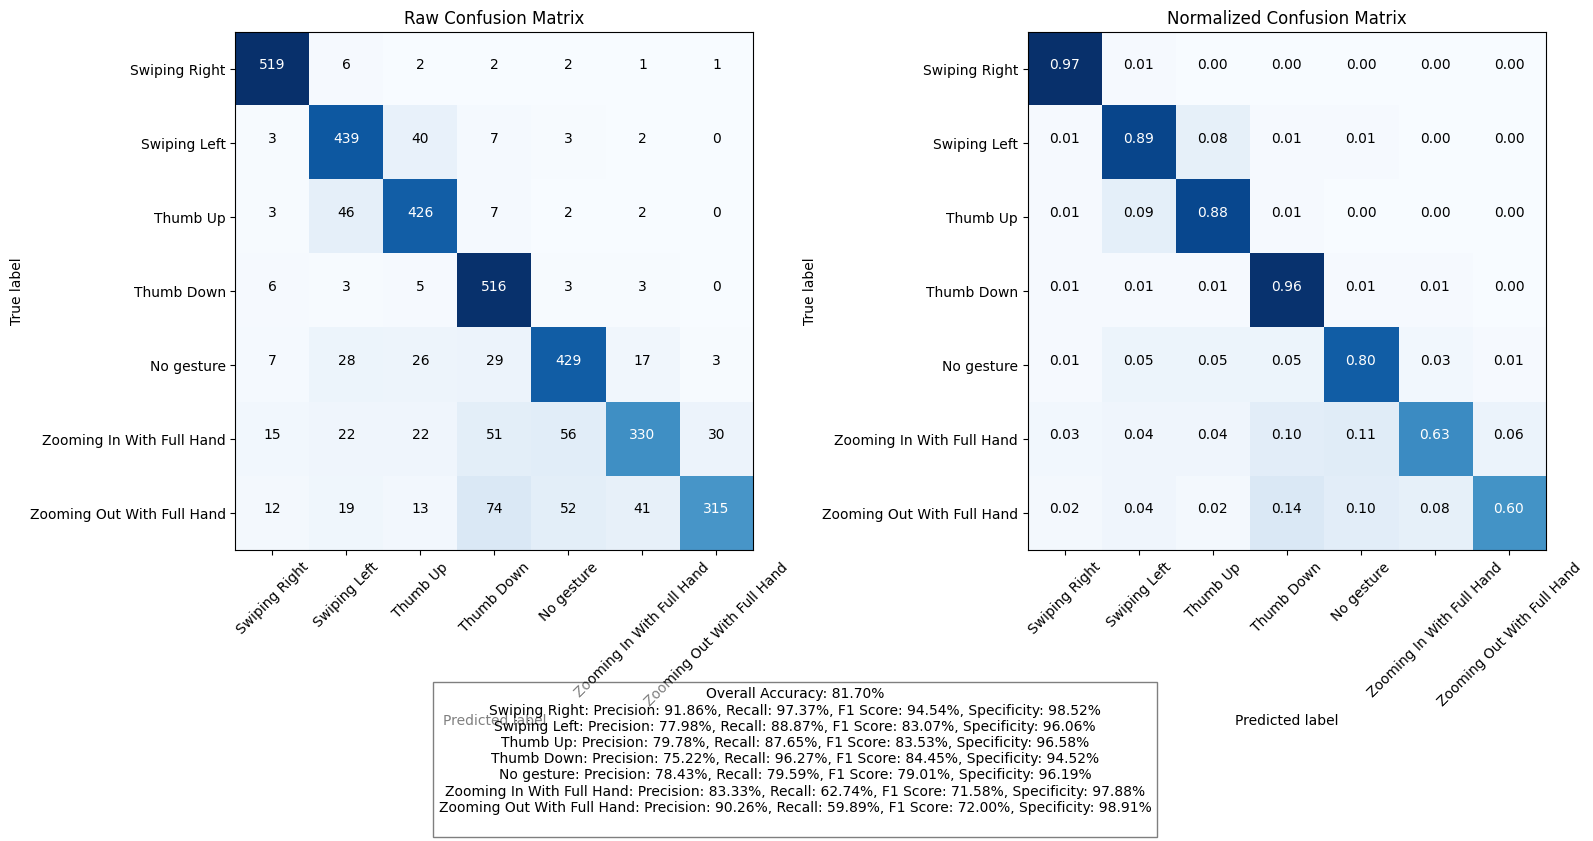

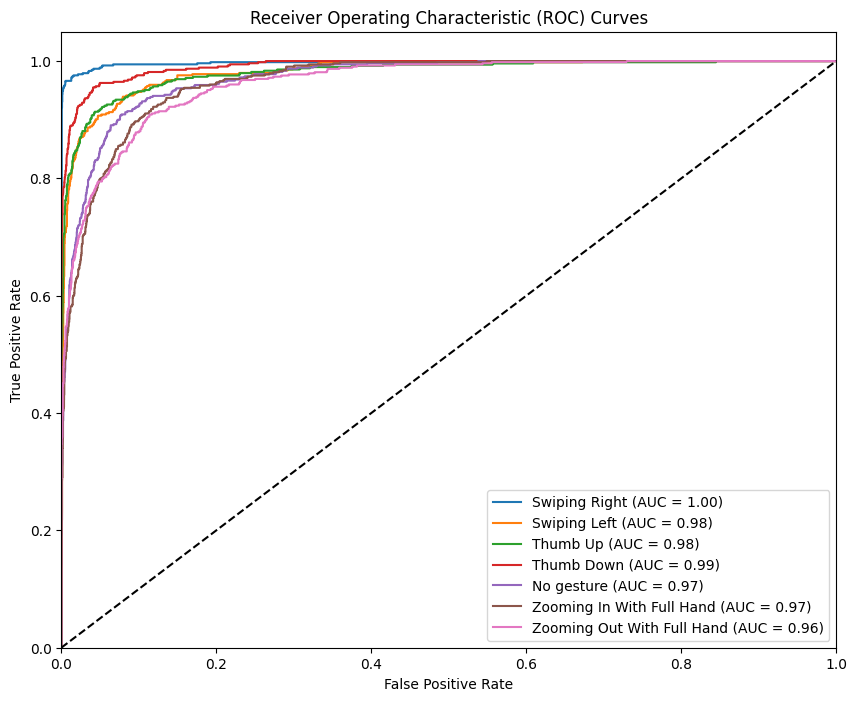

In [7]:

plot_confusion_matrices(cnn3d_model, validation_generator, gesture_list)


# 2. 3DCNN(3 layers) + 2Dlstm(2 layers) + adam

In [8]:
cnn3d_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 36, 32, 32, 36)    2952      
                                                                 
 batch_normalization (Batch  (None, 36, 32, 32, 36)    144       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 36, 16, 16, 36)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 36, 16, 16, 64)    62272     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 16, 16, 64)    256       
 chNormalization)                                                
                                                        

2/2 [==============================] - 0s 48ms/step


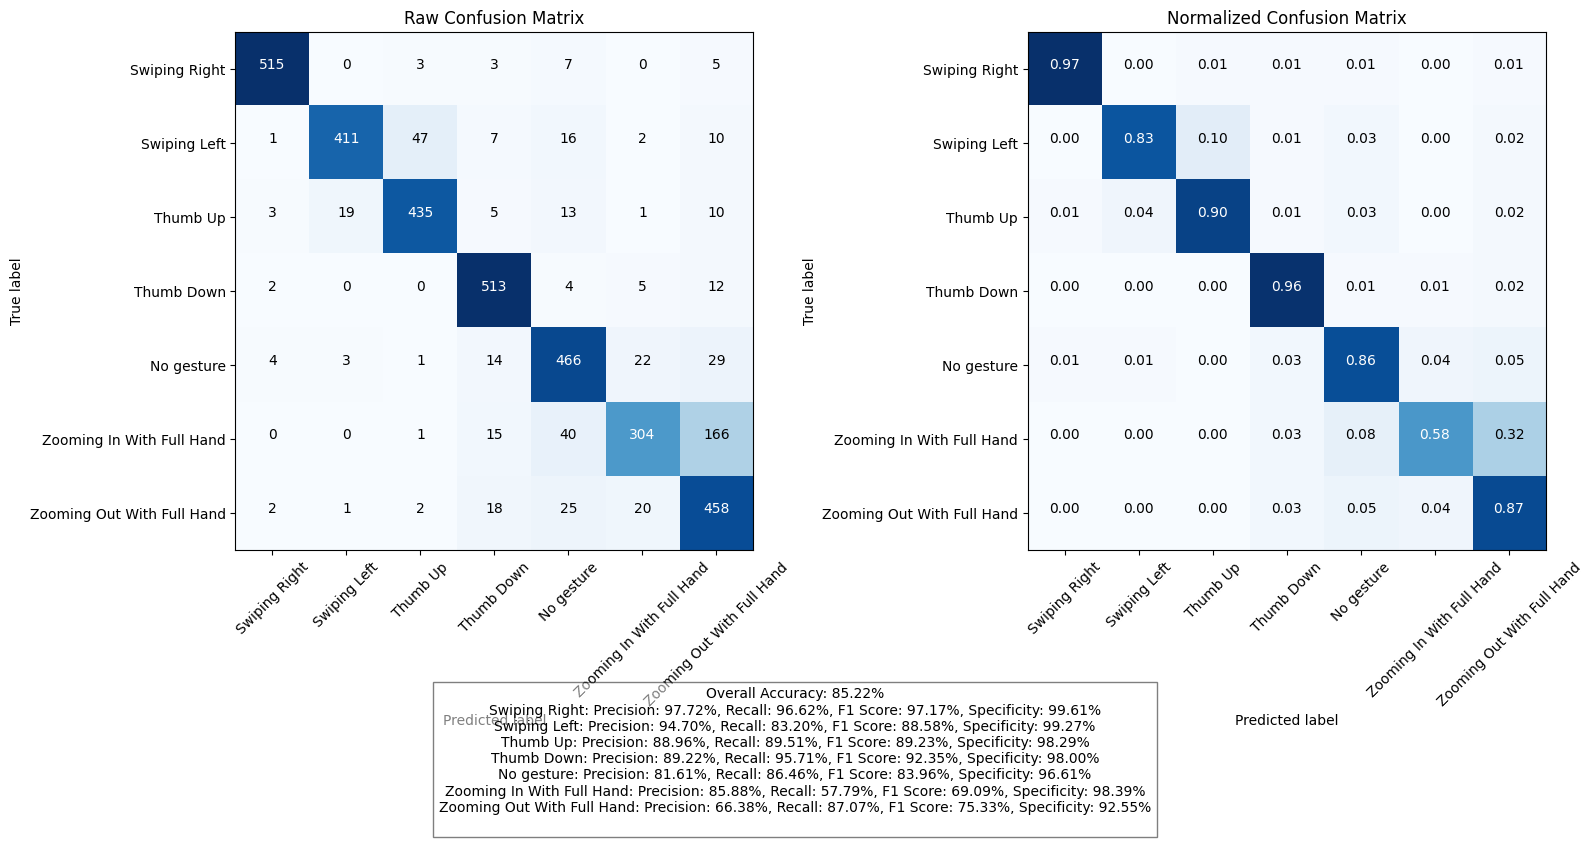

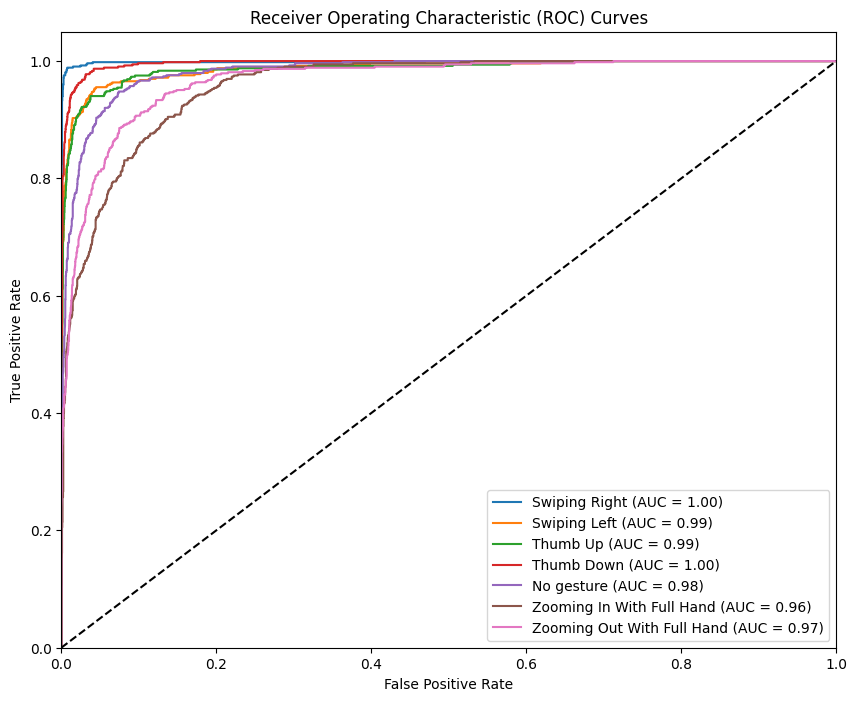

In [9]:
plot_confusion_matrices(cnn3d_lstm_model, validation_generator, gesture_list)

# 3. 3DCNN(3 layers) + 2Dlstm(3 layers) + RMSprop

In [10]:
cnn3d_lstm_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 32, 32, 36)    2952      
                                                                 
 batch_normalization (Batch  (None, 16, 32, 32, 36)    144       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 16, 16, 16, 36)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 64)    62272     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 16, 64)    256       
 chNormalization)                                                
                                                        

In [12]:
#plot_confusion_matrices(cnn3d_lstm_model1, validation_generator, gesture_list)

# 3. 3DCNN(4 layers) + 2Dlstm(1 layer) + adam

In [10]:
cnn3d_lstm_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 36, 32, 32, 32)    2624      
                                                                 
 batch_normalization (Batch  (None, 36, 32, 32, 32)    128       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 36, 16, 16, 32)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 36, 16, 16, 64)    55360     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 16, 16, 64)    256       
 chNormalization)                                                
                                                        

In [1]:
#plot_confusion_matrices(cnn3d_lstm_model2, validation_generator, gesture_list)